# Discord-alyzer

This is a project I created to analyze my best friend and I's Discord conversation history over the past 6 years and get the hang of basic data science tools. I used pandas to clean my data and find trends, matplotlib to visualize trends, NTLK to tokenize and preprocess text, and scikit-learn (K-Means, TF-idf) to get started with clustering similar messages. 

**Finished Features**
- Visualization of messages sent over time
- Visualization of trends in word usage
- Visualization of the proportion of messages sent by each member of the conversation
- Word clouds for frequently used words
- Tool to provide summaries of a day of conversation with the OpenAI API

**Works in Progress**
- Tool to cluster messages with similar themes.
- Tool to analyze sentiment of messages over time.

You can download this Jupyter Notebook and edit wherever there are comments to analyze your own Discord DM (See the README for a link to another repository that contains a tool to download Discord direct messages as CSV).

## Imports

In [6]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [8]:
pd.reset_option('all')
pd.set_option('display.max_rows', 500)
data = pd.read_csv('sample_conversation_data.csv')

# Message Count Tools

## Visualizing overall message count over time

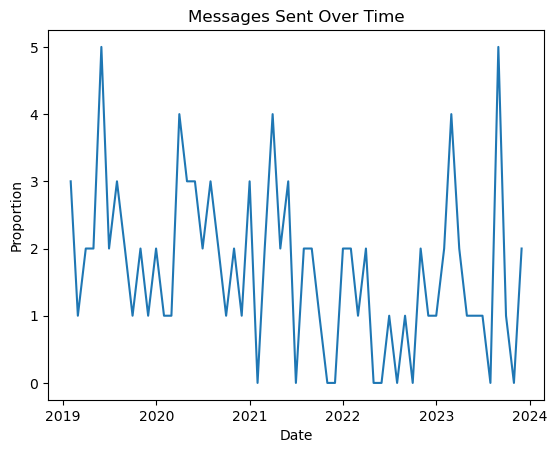

In [9]:
data = pd.read_csv('sample_conversation_data.csv') # insert the file path of the csv containing the conversation you want to analyze.
data['Date'] = pd.to_datetime(data['Date'], utc=True)

monthly_totals = data.groupby(pd.Grouper(key='Date', freq='M')).size() 

plt.plot(monthly_totals.index, monthly_totals.values)
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title(f'Messages Sent Over Time')
plt.show()

## Finding all messages in a date range

In [52]:
start_date = '2019-01-01T00:00:00.0000000-00:00' # edit with the dates and time that you want to start at.
end_date = '2019-12-31T00:00:00.0000000-00:00' # edit with the dates and time that you want to end at.

filter_data = data.loc[(data.Date > start_date) & (data.Date < end_date)]
filter_data

new_data = pd.DataFrame({
    'Date': filter_data.Date.values,
    'Author': filter_data.Author.values,
    'Content': filter_data.Content.values
})

new_data.reset_index(drop=True, inplace=True)
new_data

,Date,Author,Content
0,2019-01-12 21:09:07,user1,what's up?
1,2019-01-23 04:29:07,user2,bye lol
2,2019-01-28 02:04:19,user1,I have to go to class soon.
3,2019-02-27 19:07:30,user2,maybe tomorrow?
4,2019-03-12 13:15:30,user2,bye lol
5,2019-03-30 04:55:46,user2,sounds good!
6,2019-04-26 10:12:00,user1,no problem
7,2019-04-27 00:45:26,user2,how are you?
8,2019-05-04 01:09:16,user2,that's funny
9,2019-05-05 13:49:02,user2,I think so.


## Proportion of messages sent by each person over time

This graph doesn't really work with the dummy data, but with real data it looks pretty cool trust.

In [53]:
data = pd.read_csv('sample_conversation_data.csv') # insert the file path of the csv containing the conversation you want to analyze.

data['Date'] = pd.to_datetime(data['Date'], utc=True)

monthly_totals = data.groupby(pd.Grouper(key='Date', freq='W')).size()

sent_by_user1 = data[data['Author'] == 'user1'].groupby(pd.Grouper(key='Date', freq='W')).size() # replace 'user1' with the username of the first person in the conversation.
sent_by_user2 = data[data['Author'] == 'user2'].groupby(pd.Grouper(key = 'Date', freq = 'W')).size() # replace 'user2' with the username of the second person in the conversation.

monthly_totals = monthly_totals.replace(0, float('nan')) 

user1_proportion = sent_by_user1/monthly_totals
user2_proportion = sent_by_user2/monthly_totals

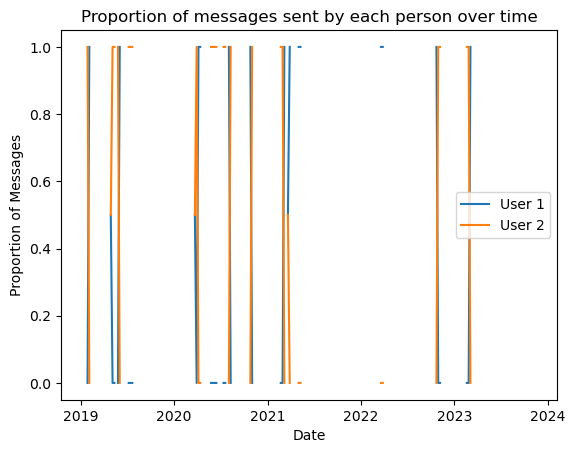

In [54]:
plt.plot(user1_proportion.index, user1_proportion.values, label = 'User 1') # Replace 'User 1' with the name of the first person in the conversation.
plt.plot(user2_proportion.index, user2_proportion.values, label = 'User 2') # Replace 'User 2' with the name of the first person in the conversation.
plt.legend()
plt.xlabel('Date')
plt.ylabel('Proportion of Messages')
plt.title(f'Proportion of messages sent by each person over time')
plt.show()

# Word Data Tools

## Count instances of a word in a period of time

In [56]:
start_date = '2019-01-01T00:00:00.0000000-00:00'
end_date = '2019-12-31T00:00:00.0000000-00:00'

word_to_count = "lol" # insert word you want to observe
instances = []
count = data.loc[(data.Date > start_date) & (data.Date < end_date)].Content.astype(str).str.contains(word_to_count, case=False, na=False).sum()
count

2

## Most used words/phrases

In [60]:
data = pd.read_csv('sample_conversation_data.csv') # insert the file path of the csv containing the conversation you want to analyze.
start_date = '2019-01-12T00:00:00.0000000-00:00' # change to match the start date you want to observe.
end_date = '2024-09-01T00:00:00.0000000-00:00' # change to match the end date you want to observe.
filtered_data = data.loc[(data.Date > start_date) & (data.Date < end_date)]
user1_data_only = filtered_data[filtered_data['Author'] == 'user1'] # insert username of first person in conversation.
user2_data_only = filtered_data[filtered_data['Author'] == 'user2'] # insert username of second person in conversation.

In [61]:
stop_words = set(stopwords.words('english')) 
custom_stop_words = {'', "'", ' ', "’"} # Define custom stop words if you'd like.

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and word not in custom_stop_words]
    return " ".join(words)

words = filtered_data['Content'].dropna().reset_index(drop=True).apply(preprocess_text) 

In [62]:
from collections import Counter
word_counts = Counter(words)
n = 10 # change depending on the number of top words you want returned.
top_words = word_counts.most_common(n+1)
i = 1
for word, count in top_words[1:n+1]:
    print(f'#{i}: {word} ({count})')
    i+=1 

#1: bye lol (9)
#2: go class soon (9)
#3: problem (9)
#4: think (9)
#5:  (8)
#6: see soon (8)
#7: whats (6)
#8: maybe tomorrow (6)
#9: thats funny (6)
#10: sure lets (6)


## Word Cloud

In [63]:
data = pd.read_csv('sample_conversation_data.csv') # insert the file path of the csv containing the conversation you want to analyze.
start_date = '2019-01-12T00:00:00.0000000-00:00' # change to match the start date
end_date = '2024-09-01T00:00:00.0000000-00:00' # change to match the end date
filtered_data = data.loc[(data.Date > start_date) & (data.Date < end_date)]
user1_data_only = filtered_data[filtered_data['Author'] == 'user1'] # insert username of first person in conversation.
user2_data_only = filtered_data[filtered_data['Author'] == 'user2'] # insert username of second person in conversation.

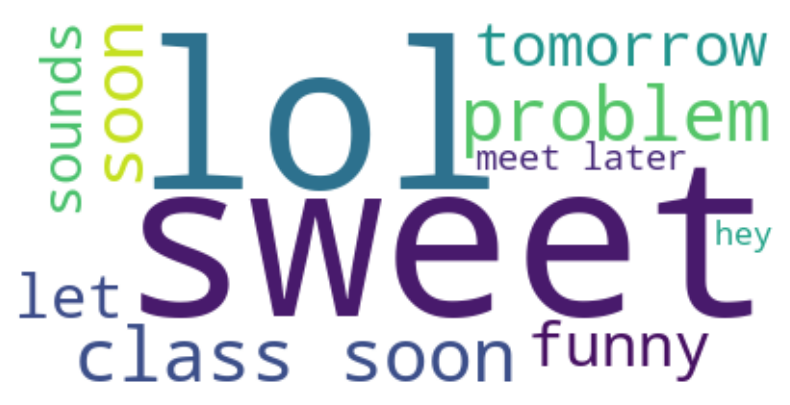

In [64]:
text_data = ' '.join(filtered_data['Content'].astype(str))

custom_stop_words = {'in', 'on', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
                     'into', 'through', 'during', 'before', 'after', 'above', 'below',
                     'to', 'from', 'up', 'down', 'over', 'under', 'again', 'further',
                     'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
                     'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',
                     'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
                     'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now',
                     'idk', 'bc', 'oh', 'yeah', 'think', 'know', 'one', 'yes', 'no', 'abt', 'im',
                     'm', 'really', 'want', 'thing', 'still', 'going', 'yea', 'good', 'mhm', 
                     'go', 'feel', 'said', 'much', 'say', 'll', 'dont', 'didn', 'real', 
                     'right', 'ok', 'okay', 'wait', 'true', 'fr', 'thats', 'ig', 'went', 'got', 
                     'way', 'like', 'maybe', 'wdym', 'hes', 'nice', 'ill', 'wa', 'yo', 'ur', 'youre', 
                     '1230', 'na', 'time', 'year', 'gon', 'https', 'tenor', 'u', 're', 'nan', 'well', 
                     'tho' "yeah", "like", "oh", "idk", "yea", "yes", "think", "well", "right", 
                    "ok", "true", "hi", "bc", "wdym", "yay", "really", "sure", "okay", "yas", "good",  
                     "mean", "actually", "maybe", "bye", "wait", "know", "yk", "yayy", "dont", "thats", 
                     "uh", "eh", "still", "say", "noo", "said", "dont know", "also", "get", "anyways", 
                     "hm", "wow", "one", "real", "whatever", "see", "something", "guess", "im", 
                     "probably", "tell", "fair", "makes sense", "interesting", "huh", "forgot", "bad",
                     "cool", "ugh", "nooo", "ya", "w"

} # edit this as you see fit. 

custom_stop_words = STOPWORDS.union(custom_stop_words)

wordcloud = WordCloud(stopwords=custom_stop_words, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Trends in word/phrase use by person

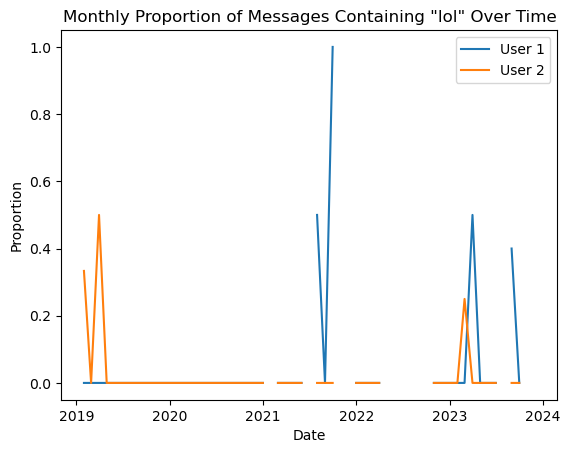

In [49]:
data = pd.read_csv('sample_conversation_data.csv')

data['Date'] = pd.to_datetime(data['Date'], utc=True)

word_to_count = 'lol' 

data['Keyword_Count'] = data['Content'].str.contains(word_to_count, case=False)

monthly_totals = data.groupby(pd.Grouper(key='Date', freq='M')).size()
monthly_totals = monthly_totals.replace(0, float('nan'))

user1_keyword_counts = data[data['Author'] == 'user1'].groupby(pd.Grouper(key='Date', freq='M'))['Keyword_Count'].sum()
user2_keyword_counts = data[data['Author'] == 'user2'].groupby(pd.Grouper(key='Date', freq='M'))['Keyword_Count'].sum()

user1_proportions = user1_keyword_counts / monthly_totals
user2_proportions = user2_keyword_counts / monthly_totals

plt.plot(user1_proportions.index, user1_proportions.values, label='User 1')
plt.plot(user2_proportions.index, user2_proportions.values, label='User 2')

plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title(f'Monthly Proportion of Messages Containing "{word_to_count}" Over Time')
plt.legend()

## Comparing usage of two words over time

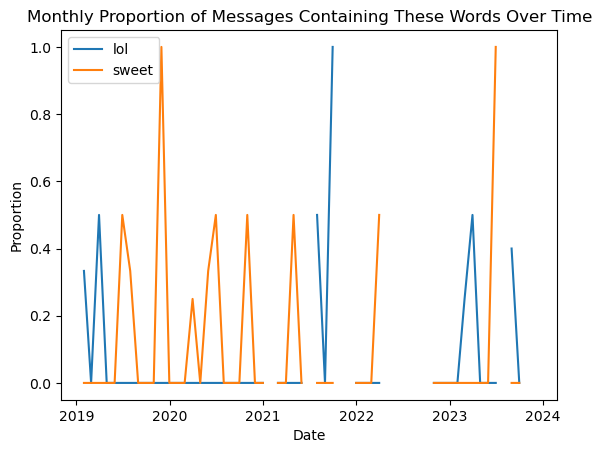

In [65]:
data = pd.read_csv('sample_conversation_data.csv')

# word 1

data['Date'] = pd.to_datetime(data['Date'], utc=True)

word_to_count = 'lol' 

data['Keyword_Count'] = data['Content'].str.contains(word_to_count, case=False)

monthly_totals = data.groupby(pd.Grouper(key='Date', freq='M')).size()

monthly_keyword_counts = data.groupby(pd.Grouper(key='Date', freq='M'))['Keyword_Count'].sum()

monthly_totals = monthly_totals.replace(0, float('nan'))  

monthly_proportions = monthly_keyword_counts / monthly_totals

plt.plot(monthly_proportions.index, monthly_proportions.values, label = word_to_count)
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title(f'Monthly Proportion of Messages Containing These Words Over Time')


# word 2 

data['Date'] = pd.to_datetime(data['Date'], utc=True)

word_to_count = 'sweet' 

data['Keyword_Count'] = data['Content'].str.contains(word_to_count, case=False)

monthly_totals = data.groupby(pd.Grouper(key='Date', freq='M')).size()

monthly_keyword_counts = data.groupby(pd.Grouper(key='Date', freq='M'))['Keyword_Count'].sum()

monthly_totals = monthly_totals.replace(0, float('nan'))  

monthly_proportions = monthly_keyword_counts / monthly_totals

plt.plot(monthly_proportions.index, monthly_proportions.values, label = word_to_count)

plt.legend()
plt.show()

# Day Summary Tool

This tool retrieves all messages from one day and summarizes them. If you have an OpenAI key, you can insert it into the code and it will do the rest for you. 

In [69]:
data = pd.read_csv('sample_conversation_data.csv')
date = '2023-07-15'
start_time = f'{date}T00:00:00.0000000-00:00'
end_time = f'{date}T23:59:59.9999999-00:00'

filter_data = data.loc[(data.Date > start_time) & (data.Date < end_time)]
filter_data

new_data = pd.DataFrame({
    'Author': filter_data.Author.values,
    'Content': filter_data.Content.values
})

new_data.reset_index(drop=True, inplace=True)
conversation_data = new_data.to_json()

In [70]:
import openai

openai.api_key = "" # insert your open ai key here.

response = openai.ChatCompletion.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are an assistant that specializes in summarizing conversations."},
        {"role": "user", "content": f"This is a day’s worth of conversation between two people. Summarize and try to deduce what happened on the day the content of this day in 3-5 paragraphs. Be specific about names of people, places, media, and items mentioned. Here is the conversation: {conversation_data}"}
    ]
)

print(response['choices'][0]['message']['content'])
    

On this day, two individuals, identified as user1 and user2, engaged in a brief yet amicable conversation. The interaction appears to have been casual and friendly, marked by typical greetings and inquiries about each other's well-being. Both participants expressed that they were doing well, suggesting a positive tone throughout their exchange.

As the conversation progressed, user1 and user2 indicated that they were both busy with work-related tasks. This shared experience of working on something likely implies a common professional or academic environment, though specific details about their respective projects remain undisclosed. They both seemed to appreciate the mutual understanding of their busy schedules.

Towards the end of their exchange, user1 proposed to catch up later, to which user2 agreed. This suggests that both parties value their relationship and are interested in maintaining communication despite their current commitments. The conversation concluded with both saying g

# Conversation Topic Clustering (WIP)

This one's a little messy and doesn't work with the dummy data. Though if you upload your own data, some of the key words in each cluster are actually connected which is cool. 

In [72]:
data = pd.read_csv('sample_conversation_data.csv')
start_date = '2019-09-01T00:00:00.0000000-00:00'
end_date = '2023-10-01T00:00:00.0000000-00:00'
data = data.loc[(data.Date > start_date) & (data.Date < end_date)]
data = data.reset_index(drop = True)

In [73]:
stop_words = set(stopwords.words('english')) 
custom_stop_words = {'in', 'on', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
                     'into', 'through', 'during', 'before', 'after', 'above', 'below',
                     'to', 'from', 'up', 'down', 'over', 'under', 'again', 'further',
                     'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
                     'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',
                     'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
                     'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now',
                     'idk', 'bc', 'oh', 'yeah', 'think', 'know', 'one', 'yes', 'no', 'abt', 'im',
                     'm', 'really', 'want', 'thing', 'still', 'going', 'yea', 'good', 'mhm', 
                     'go', 'feel', 'said', 'much', 'say', 'll', 'dont', 'didn', 'real', 
                     'right', 'ok', 'okay', 'wait', 'true', 'fr', 'thats', 'ig', 'went', 'got', 
                     'way', 'like', 'maybe', 'wdym', 'hes', 'nice', 'ill', 'wa', 'yo', 'ur', 'youre', 
                     '1230', 'na', 'gon', "noo", "tbh", "90", "hm", "well", "see", "might", "pls", "ive"
}

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and word not in custom_stop_words]
    return " ".join(words)

texts = data['Content'].dropna().reset_index(drop=True).apply(preprocess_text)

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Assuming 'texts' is your list of documents
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.85, min_df=5, ngram_range=(1, 3))
X = vectorizer.fit_transform(texts)

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, random_state=0)
kmeans.fit(X)

# Assuming 'data' is your DataFrame and 'texts' is the index
data['cluster'] = pd.Series(kmeans.labels_, index=texts.index)

def get_top_terms_per_cluster(kmeans, vectorizer, num_terms=10):
    terms = vectorizer.get_feature_names_out()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    top_terms = {}
    for i in range(num_clusters):
        top_terms[i] = [terms[ind] for ind in order_centroids[i, :num_terms]]
    return top_terms

top_terms = get_top_terms_per_cluster(kmeans, vectorizer)

for cluster_num, terms in top_terms.items():
    print(f"Cluster {cluster_num}: {', '.join(terms)}")


Cluster 0: class soon, class, soon, whats, tomorrow, sweet, sure lets, sure, problem, lol
Cluster 1: whats, tomorrow, sweet, sure lets, sure, soon, problem, lol, lets, class soon
Cluster 2: problem, whats, tomorrow, sweet, sure lets, sure, soon, lol, lets, class soon
Cluster 3: lol, bye lol, bye, whats, tomorrow, sweet, sure lets, sure, soon, problem
Cluster 4: sweet, whats, tomorrow, sure lets, sure, soon, problem, lol, lets, class soon
Cluster 5: soon, whats, tomorrow, sweet, sure lets, sure, problem, lol, lets, class soon
Cluster 6: lets, sure lets, sure, whats, tomorrow, sweet, soon, problem, lol, class soon
Cluster 7: tomorrow, whats, sweet, sure lets, sure, soon, problem, lol, lets, class soon
Cluster 8: whats, tomorrow, sweet, sure lets, sure, soon, problem, lol, lets, class soon
Cluster 9: bye, whats, tomorrow, sweet, sure lets, sure, soon, problem, lol, lets


In [75]:
# cluster distribution
cluster_counts = pd.Series(kmeans.labels_).value_counts()
print(cluster_counts)

1    31
0     8
2     7
4     7
5     6
6     6
8     5
7     5
3     5
9     2
Name: count, dtype: int64


In [76]:
# print columns of text in different clusters

cluster = 2
data[data.cluster == cluster]

,Date,Author,Content,cluster
2,2019-10-15T11:40:42.000000,user2,no problem,2
11,2020-03-25T08:00:51.000000,user2,no problem,2
20,2020-07-07T15:08:24.000000,user2,no problem,2
30,2020-12-04T15:26:33.000000,user1,no problem,2
48,2021-12-08T10:41:03.000000,user2,no problem,2
65,2023-02-17T11:43:19.000000,user2,no problem,2
66,2023-02-21T02:57:05.000000,user2,no problem,2
